# Данные

In [ ]:
import shutil

# Пытаемся взять copy_tree из distutils или setuptools._distutils
try:
    from distutils.dir_util import copy_tree
except ImportError:
    # Для Python 3.12+, где distutils выпилен, но есть в setuptools
    from setuptools._distutils.dir_util import copy_tree  # type: ignore

# Если в shutil нет copy_tree — добавляем
if not hasattr(shutil, "copy_tree"):
    shutil.copy_tree = copy_tree  # type: ignore


import moabb.datasets

m_dataset = moabb.datasets.BI2013a(
    NonAdaptive=True,
    Adaptive=True,
    Training=True,
    Online=True,
)

m_dataset.download()

In [133]:
from moabb.paradigms import P300

paradigm = P300()  # или P300(fmin=1, fmax=20, ...) при желании

X, y, meta = paradigm.get_data(
    dataset=m_dataset,
    subjects=[1],   # список субъектов
)

print(X.shape)     # (n_trials, n_channels, n_times)
print(y.shape)     # (n_trials,)
print(meta.head())

/home/mamura/.conda/envs/ais/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/mamura/.conda/envs/ais/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/mamura/.conda/envs/ais/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/mamura/.conda/envs/ais/lib/python3.12/si

(8292, 16, 513)
(8292,)
   subject session run
0        1       2   0
1        1       2   0
2        1       2   0
3        1       2   0
4        1       2   0


In [135]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [138]:
import torch
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.pipeline import Pipeline

le = LabelEncoder()
y_enc = le.fit_transform(y)
 
print("Classes:", le.classes_)
print("Encoded y:", np.unique(y_enc))


X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, random_state=42, test_size=0.2, stratify=y_enc
)

y_train_svm = 2 * y_train - 1   # 0 -> -1, 1 -> +1
y_test_svm  = 2 * y_test - 1

flatten = FunctionTransformer(
    lambda X: X.reshape(X.shape[0], -1),  # (N, C, T) -> (N, C*T)
    validate=False
)

pipe = Pipeline([
    ("flatten", flatten),
    ("scaler", StandardScaler()),
])

X_train_scaled = pipe.fit_transform(X_train)
X_test_scaled = pipe.transform(X_test)      

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_np = X_train_scaled.astype(np.float32)
X_test_np  = X_test_scaled.astype(np.float32)

y_train_svm_np = y_train_svm.astype(np.float32)
y_test_svm_np  = y_test_svm.astype(np.float32)


Classes: ['NonTarget' 'Target']
Encoded y: [0 1]
X_train_scaled shape: (6633, 8208)
X_test_scaled shape: (1659, 8208)


# Модель

In [139]:
torch.cuda.is_available()

True

In [140]:
class SVM(nn.Module):
    def __init__(self, input_size: int):
        super(SVM, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

model = SVM(input_size=X_train_tensor.shape[1]).to('cuda')

In [141]:
print(model)

SVM(
  (linear): Linear(in_features=8208, out_features=1, bias=True)
)


In [142]:
def hinge_loss(y_true, y_pred):
    y_true = y_true.view(-1, 1)
    y_pred = y_pred.view(-1, 1)
    return torch.mean(torch.clamp(1 - y_true * y_pred, min=0))

In [145]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_svm_torch(
    X_train_np,
    y_train_svm_np,
    X_val_np,
    y_val_binary_np,
    C: float,
    epochs: int = 300,
    batch_size: int = 64,
    lr: float = 1e-2,
    device: str = "cpu",
):
    n_features = X_train_np.shape[1]

    model = SVM(input_size=n_features).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    train_dataset = TensorDataset(
        torch.from_numpy(X_train_np),
        torch.from_numpy(y_train_svm_np),
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    history_loss = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch).view(-1)
            loss_margin = hinge_loss(y_batch, y_pred)
            l2_reg = 0.5 * torch.sum(model.linear.weight ** 2)

            loss = l2_reg + C * loss_margin

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * X_batch.size(0)

        epoch_loss /= len(train_loader.dataset)
        history_loss.append(epoch_loss)

        if (epoch + 1) % 100 == 0:
            print(f"C={C}, epoch {epoch+1}, loss={epoch_loss:.4f}")

    model.eval()
    with torch.no_grad():
        X_val_t = torch.from_numpy(X_val_np).to(device)
        scores = model(X_val_t).view(-1)
        y_pred_svm = torch.sign(scores).cpu().numpy()
        y_pred_binary = (y_pred_svm > 0).astype(int)

    acc = accuracy_score(y_val_binary_np, y_pred_binary)
    prec = precision_score(y_val_binary_np, y_pred_binary, zero_division=0)
    rec = recall_score(y_val_binary_np, y_pred_binary, zero_division=0)
    f1 = f1_score(y_val_binary_np, y_pred_binary, zero_division=0)

    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }

    return model, history_loss, metrics

In [146]:
C_values = [0.01, 0.1, 1.0, 10.0]
results_loss = {}   
results_metrics = {}

for C in tqdm(C_values, 'Models: '):
    print(f"\n=== Обучаем модель с C={C} ===")
    model, history_loss, metrics = train_svm_torch(
        X_train_np,
        y_train_svm_np,
        X_test_np,  
        y_test,   
        C=C,
        epochs=300,
        batch_size=64,
        lr=1e-2,
        device="cuda",
    )

    results_loss[C] = history_loss
    results_metrics[C] = metrics

    print(f"C={C} | "
          f"acc={metrics['accuracy']:.3f}, "
          f"f1={metrics['f1']:.3f}, "
          f"precision={metrics['precision']:.3f}, "
          f"recall={metrics['recall']:.3f}")


Models:   0%|          | 0/4 [00:00<?, ?it/s]


=== Обучаем модель с C=0.01 ===
C=0.01, epoch 100, loss=0.0046
C=0.01, epoch 200, loss=0.0032
C=0.01, epoch 300, loss=0.0032
C=0.01 | acc=0.841, f1=0.083, precision=1.000, recall=0.043

=== Обучаем модель с C=0.1 ===
C=0.1, epoch 100, loss=0.0239
C=0.1, epoch 200, loss=0.0239
C=0.1, epoch 300, loss=0.0239
C=0.1 | acc=0.913, f1=0.686, precision=0.863, recall=0.569

=== Обучаем модель с C=1.0 ===
C=1.0, epoch 100, loss=0.2487
C=1.0, epoch 200, loss=0.2328
C=1.0, epoch 300, loss=0.2345
C=1.0 | acc=0.913, f1=0.740, precision=0.737, recall=0.743

=== Обучаем модель с C=10.0 ===
C=10.0, epoch 100, loss=9.9219
C=10.0, epoch 200, loss=9.9486
C=10.0, epoch 300, loss=9.8181
C=10.0 | acc=0.892, f1=0.694, precision=0.654, recall=0.739


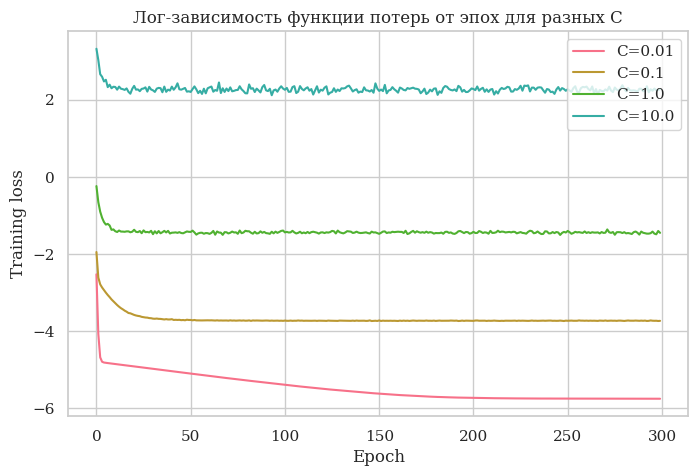

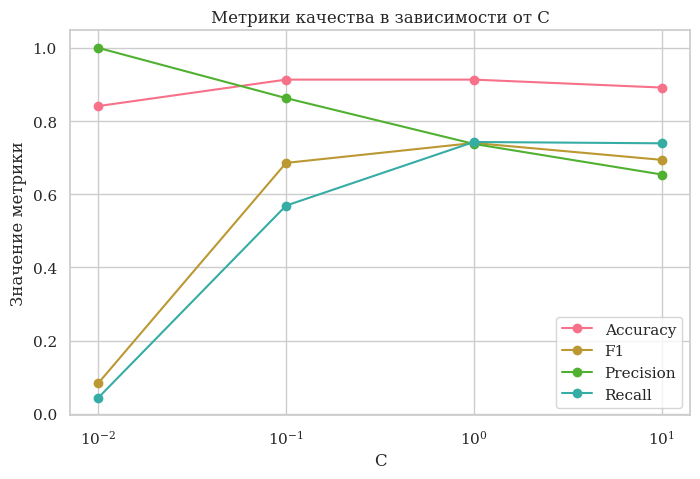

In [149]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for C, history_loss in results_loss.items():
    plt.plot(np.log(history_loss), label=f"C={C}")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.title("Лог-зависимость функции потерь от эпох для разных C")
plt.legend()
plt.grid(True)
plt.show()

Cs = list(results_metrics.keys())
accs = [results_metrics[C]["accuracy"] for C in Cs]
f1s = [results_metrics[C]["f1"] for C in Cs]
precs = [results_metrics[C]["precision"] for C in Cs]
recs = [results_metrics[C]["recall"] for C in Cs]

plt.figure(figsize=(8, 5))
plt.plot(Cs, accs, marker="o", label="Accuracy")
plt.plot(Cs, f1s, marker="o", label="F1")
plt.plot(Cs, precs, marker="o", label="Precision")
plt.plot(Cs, recs, marker="o", label="Recall")
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Значение метрики")
plt.title("Метрики качества в зависимости от C")
plt.legend()
plt.grid(True)
plt.show()
